## Baseline Experiment and Evaluation

### The unfair TOS dataset from hugging face consists of 8+1 lables for tasks involving classifying unfair terms of service for legal documents commonly occuring in the web. The dataset is in itself very sparsely labelled and has very little encoded information about everything. We will first start with visualizing the data and seeing if we can identify any patterns present in the data itself. 

### Visualization
1. TF-IDF Visualization
2. Term frequency analysis and Legal term frequeny analysis
3. Topic modeling
4. Companies and major infarctions



In [29]:
#------# Import libraries and datasets #------#

import numpy as np
import torch
import datasets as dts
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


### Visualization

1. Basic visualization examples

In [2]:
dataset = dts.load_dataset('lex_glue','unfair_tos')

Found cached dataset lex_glue (/home/anas/.cache/huggingface/datasets/lex_glue/unfair_tos/1.0.0/8a66420941bf6e77a7ddd4da4d3bfb7ba88ef48c1d55302a568ac650a095ca3a)


  0%|          | 0/3 [00:00<?, ?it/s]

                                                text labels
0  notice to california subscribers : you may can...     []
1  if you subscribed using your apple id , refund...     []
2  if you wish to request a refund , please visit...     []
3  if you subscribed using your google play store...     []
4  key changes in this version : we 've included ...     []

 Number of instances per label
 []           4902
[0]           177
[2]            92
[1]            92
[4]            74
[3]            43
[5]            33
[7]            28
[6]            28
[3, 1]         21
[2, 1]         15
[5, 6]          6
[0, 2, 1]       5
[0, 1]          3
[3, 2]          3
[3, 0]          2
[3, 2, 1]       2
[4, 2]          2
[0, 2]          2
[3, 0, 1]       1
[3, 0, 2]       1
Name: labels, dtype: int64


<AxesSubplot:ylabel='labels'>

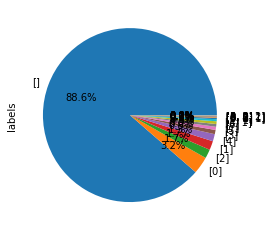

In [3]:
train_data = pd.DataFrame.from_dict(dataset['train'])
test_data = pd.DataFrame.from_dict(dataset['test'])
val_data = pd.DataFrame.from_dict(dataset['validation'])


# Print first five instances of the data
print (train_data.head())
print ("\n Number of instances per label\n",train_data['labels'].value_counts())

# Plotting the target to visualize the labels better
train_data['labels'].value_counts().plot.pie(autopct='%1.1f%%')

# Over 86% of the data doesnot have any label. This lop-sided data distribution might causes issues in the future.
# The most commonly occuring pair of lables are 3,1 which should be investigated further.

                                                   text  labels  word length
0     notice to california subscribers : you may can...      []           34
1     if you subscribed using your apple id , refund...      []           18
2     if you wish to request a refund , please visit...      []           13
3     if you subscribed using your google play store...      []           18
4     key changes in this version : we 've included ...      []           29
...                                                 ...     ...          ...
5527  any failure by us to enforce any of these term...      []           32
5528  a person who is not a party to these terms sha...      []           23
5529  irrespective of the country from which you acc...  [5, 6]           75
5530  if you require further information about skysc...      []           28
5531  alternatively , you can write to us at quarter...      []           30

[5532 rows x 3 columns]


<AxesSubplot:>

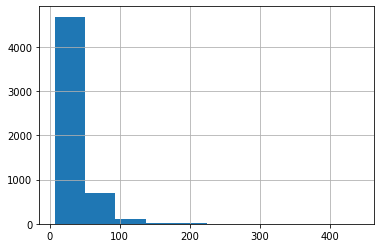

In [4]:
'''Now we should find out the average length of the word inside the data and text.'''
def wl(text):
    return len(text.split(' '))

train_data["word length"]=train_data["text"].apply(wl)
print(train_data)
train_data["word length"].hist()

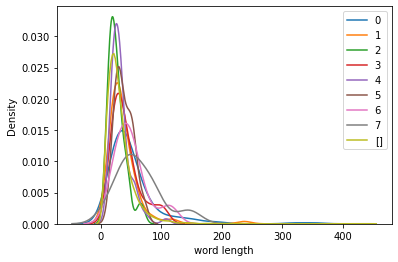

In [5]:
plt_len_data = []
for i in range(0,8):
    sns.kdeplot(train_data[train_data["labels"].apply(lambda x: x == [i]).values]['word length'])
    plt_len_data.append(str(i))
sns.kdeplot(train_data[train_data["labels"].apply(lambda x: x == []).values]['word length'])
plt_len_data.append(str("[]"))

plt.legend(plt_len_data)
# General trend, the more words a sentence contains, the less likely it contains labels

<AxesSubplot:>

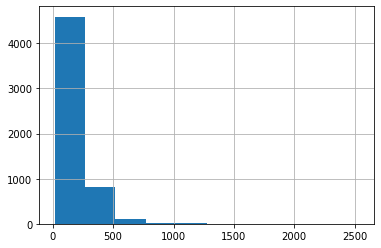

In [6]:
train_data['char_length']=train_data['text'].apply(len)
train_data['char_length'].hist()
# pretty undescriptive to be honest

<AxesSubplot:xlabel='char_length', ylabel='word length'>

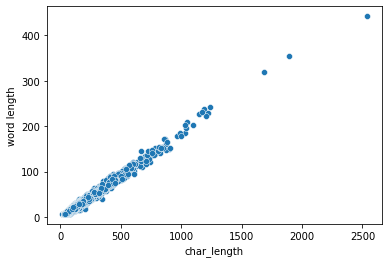

In [7]:
sns.scatterplot(x='char_length',y='word length',data=train_data)
# the char length and the word length are linearly related

<AxesSubplot:>

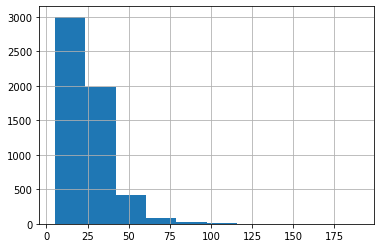

In [8]:
train_data['unique_word_count'] =train_data['text'].apply(lambda x: len(set(str(x).split())))
train_data['unique_word_count'].hist()
# The training data has a lot of unique words, with a lot of less repetition

            word length  char_length  unique_word_count  stop_words
str_labels                                                         
[0, 1]              143          772                103          61
[0, 2, 1]           228         1228                161          90
[0, 2]               52          281                 45          20
[0]                9252        49367               6236        3754
[1]                3470        18322               2597        1438
[2, 1]              478         2419                349         186
[2]                2455        12728               1934         973
[3, 0, 1]           108          581                 73          42
[3, 0, 2]            46          228                 29          13
[3, 0]               64          353                 49          26
[3, 1]             1209         6483                840         465
[3, 2, 1]           183          964                122          76
[3, 2]               78          396            

<AxesSubplot:xlabel='str_labels', ylabel='stop_words'>

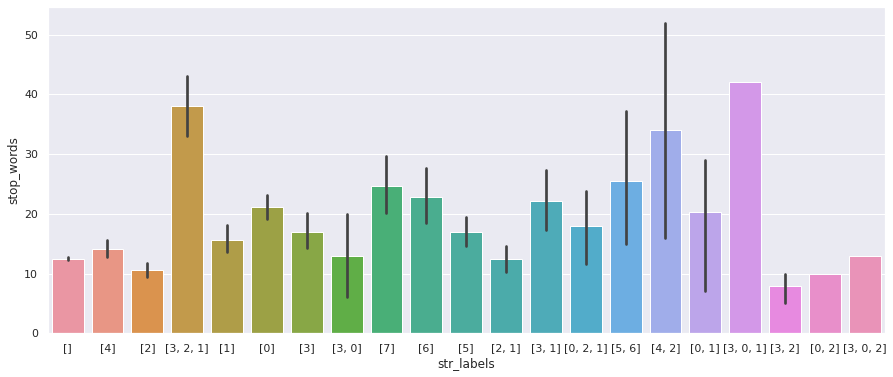

In [26]:
# Finding out the stop word in a sentence

all_stopwords = stopwords.words('english')
train_data['stop_words']=train_data['text'].apply(lambda x: len([words for words in str(x).lower().split() if words in all_stopwords]))
train_data['str_labels']=train_data['labels'].apply(str)
new_data = train_data.groupby('str_labels').sum()
print (new_data)

sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x='str_labels',y='stop_words',data=train_data,)

# sentences with multiple labels have more stop words than single labels. Sentences with no lable have 
# very few stop words

<AxesSubplot:>

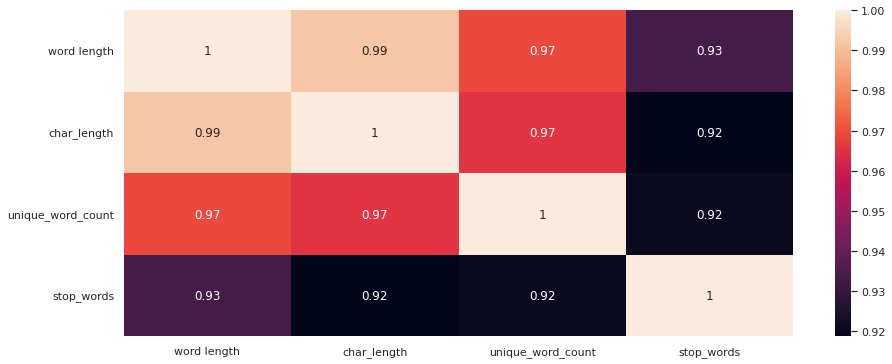

In [27]:
corr=train_data.corr()
sns.heatmap(corr,annot=True)

services 1538
use 1471
service 1241
terms 1178
content 1041
information 573
including 569
account 561
agree 529
party 522
skype 488
user 482
rights 460
software 413
time 394


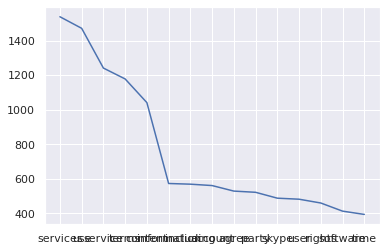

In [32]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(train_data['text'], 15)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.plot(df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False))

use services 221
use service 170
terms use 168
intellectual property 168
user content 131
terms conditions 122
world warcraft 119
applicable law 118
including limitation 117
blizzard entertainment 117
privacy policy 115
united states 114
yahoo services 105
including limited 101
extent permitted 86


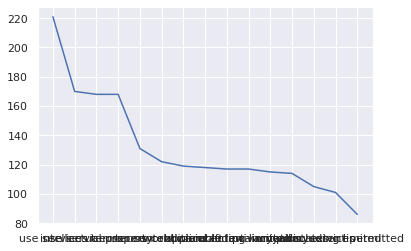

In [33]:

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(train_data['text'], 15)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.plot(df4.groupby('ReviewText').sum()['count'].sort_values(ascending=False))

# apart from the company names, most of data contains terms of service
# and other legal jargon

use of the 247
of the service 190
the right to 179
your use of 157
of the services 155
terms of use 154
of these terms 135
in connection with 134
at any time 132
any third party 131
you agree to 124
these terms of 123
world of warcraft 119
terms and conditions 118
including without limitation 117


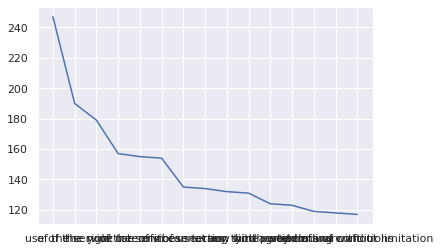

In [34]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(train_data['text'], 15)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.plot(df5.groupby('ReviewText').sum()['count'].sort_values(ascending=False))

# most of service actually try to inform the user of their rights (thankfully).
# the data also contains a lot of stuff about third party interactions

at any time 81
the right to 67
reserves the right 49
use of the 48
arising out of 44
of the service 43
terms of use 42
in connection with 38
out of or 37
extent permitted by 35
your access to 34
these terms of 33
from time to 33
time to time 33
you agree to 31


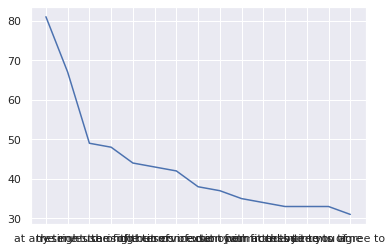

In [38]:
problematic_data = train_data[train_data["labels"].apply(lambda x: x != []).values]
common_words = get_top_n_trigram(problematic_data['text'], 15)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
plt.plot(df6.groupby('ReviewText').sum()['count'].sort_values(ascending=False))

# interesting to see that most of the trigrams for data-frame contain stuff like at any time and you 
# accept these terms of agreement